In [101]:
import sympy
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from sympy.functions.special.polynomials import chebyshevt
from scipy.stats import beta
from qiskit.circuit.library import PolynomialPauliRotations
from qiskit.visualization import plot_histogram
from qiskit_algorithms import IterativeAmplitudeEstimation,EstimationProblem
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
sampler = Sampler(mode=backend)

# Submit the circuit to Sampler
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

We are using the aer_simulator quantum computer


In [43]:
try:
    # Input
    func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
    lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
    upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

    # Define the symbols
    x = sympy.symbols('x', real=True)
    expected_symbols = {x}

    # Parse the Function String
    local_dict = {'x': x}
    global_dict = sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application, convert_xor)
    func_expr = parse_expr(func_str,
                           local_dict=local_dict,
                           global_dict=global_dict,
                           transformations=transformations)

    # VALIDATE
    found_symbols = func_expr.free_symbols
    if not found_symbols.issubset(expected_symbols):
        unknown_symbols = found_symbols - expected_symbols
        raise ValueError(f"Function contains unknown variables: {unknown_symbols}. "
                         f"The expression must only depend on 'x'.")

    # --- Finalize Inputs ---
    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func = sympy.simplify(func_expr)
    
    # --- Display the problem ---
    integral_expr = sympy.Integral(func, (x, lower_limit, upper_limit))
    print("\nEntered definite integral Mathematical expression:")
    display(integral_expr)

    # Convert limits to floats to prevent constants parsing errors
    try:
        lower_limit_f = float(lower_limit)
        upper_limit_f = float(upper_limit)
    except TypeError:
        lower_limit_f = float(lower_limit.evalf())
        upper_limit_f = float(upper_limit.evalf())

    lower_limit=lower_limit_f
    upper_limit= upper_limit_f
except Exception as e:
    print(f"\nError: Could not process the input. Please check the expression. \nDetails: {e}")


Entered definite integral Mathematical expression:


9      
⌠      
⎮  2   
⎮ x  dx
⌡      
0      

In [3]:
def getChebyshevPolynomial( sympy_symbol,sympy_func ,degree, lower_limit, upper_limit):
    """
    Generates a high-quality Chebyshev polynomial approximation for a given SymPy function
    using NumPy's fitting method.
    This is the ideal method because Taylor's approximation requires O(d^2) oracle calls.
    Chebyshev approximation also uniformly distributes the error in the range making it ideal for this scenario.
    """
    print(f"Chebyshev Approximation to {degree}th degree:\n")

    # 1. Callable numerical version of the function "Oracle"
    f_numeric = sympy.lambdify(sympy_symbol, sympy_func, 'numpy')

    # 2. Define the coordinate transformation from [lower_limit, upper_limit] to [-1, 1]
    jac_scaling = (upper_limit - lower_limit) / 2.0
    offset = (upper_limit + lower_limit) / 2.0
    
    # This is f(x) re-parameterized in terms of y. This is the function we will approximate.
    func_to_approximate = lambda y_val: f_numeric(jac_scaling * y_val + offset)

    # 3. Generate sample points and query the oracle to get data for fitting
    # For a degree `d` polynomial, we need at least `d+1` points. 2*degree is ideal
    num_samples = 2 * degree
    sample_points_y = np.linspace(-1, 1, num_samples)
    sample_values_f = func_to_approximate(sample_points_y)

    # 4. Use NumPy to fit the Chebyshev polynomial to the sampled data
    cheb_poly_fit = np.polynomial.chebyshev.Chebyshev.fit(
        sample_points_y,
        sample_values_f,
        deg=degree
    )
    
    # The coefficients are ordered from T_0 to T_d
    coeffs = cheb_poly_fit.convert().coef
    print(f"Found {len(coeffs)} coefficients.")

    # 5. Calculate the scaling factor M = max(|f(x)|)
    # We find the max value by evaluating our new high-quality approximation on a fine grid.
    fine_grid_y = np.linspace(-1, 1, 1000)
    interpolation_f =(cheb_poly_fit(fine_grid_y))
    m= np.min(interpolation_f)
    M = np.max(interpolation_f)
    print(f"M value for scaling is: {M:.4f}")

    # 6. Reconstruct a SymPy expression for display and symbolic integration
    # The polynomial for the integral must approximate g(y) = f(x) * jac_scaling
    y_sym = sympy.Symbol('y')
    chebyshev_sympy_f = sum(coeffs[i] * chebyshevt(i, y_sym) for i in range(len(coeffs)))
    chebyshev_sympy_g = jac_scaling * chebyshev_sympy_f

    integration_expr = sympy.Integral(chebyshev_sympy_g, (y_sym, -1, 1))
    print("\nApproximated Integral (Chebyshev Polynomial on [-1, 1]):")
    display(integration_expr)
    
    # 7. New: Explicitly check the endpoint error to verify the quality
    true_val_at_endpoint = func_to_approximate(1.0) # This is f(upper_limit)
    approx_val_at_endpoint = cheb_poly_fit(1.0)
    abs_error = np.abs(true_val_at_endpoint - approx_val_at_endpoint)
    
    print(f"\nError analysis at endpoint y=1 (x={upper_limit}):")
    print(f"  - True value of f({upper_limit}) = {true_val_at_endpoint:.8f}")
    print(f"  - Approx value from poly = {approx_val_at_endpoint:.8f}")
    print(f"  - Absolute Error = {abs_error:.2e}")

    return coeffs,m ,M, chebyshev_sympy_g

In [4]:
def extract_quantum_coefficients(coeffs, m, M, n_qubits):
    """
    Extract coefficients for quantum state preparation from Chebyshev approximation.
    
    Parameters:
    -----------
    coeffs : array-like
        Chebyshev polynomial coefficients from your approximation
    m : float
        Minimum value of the function
    M : float
        Maximum value of the function
    n_qubits : int
        Number of qubits for the quantum state
    
    Returns:
    --------
    theta_coeffs : list
        Coefficients for θ(i) polynomial where i ∈ [0, 2^n - 1]
    scaling_info : dict
        Information about the scaling applied
    """
    
    # Number of basis states
    N = 2**n_qubits
    
    # Step 1: Scale the Chebyshev polynomial to have range [0, 1]
    # If f(x) has range [m, M], then (f(x) - m)/(M - m) has range [0, 1]
    range_scale = M - m
    if range_scale == 0:
        raise ValueError("Function has constant value, cannot scale")
    
    # Adjust coefficients for the vertical scaling
    # The constant term needs special handling
    scaled_coeffs = coeffs.copy()
    scaled_coeffs[0] = (coeffs[0] - m) / range_scale
    for i in range(1, len(coeffs)):
        scaled_coeffs[i] = coeffs[i] / range_scale
    
    print(f"Scaling from range [{m:.4f}, {M:.4f}] to [0, 1]")
    print(f"Scaled Chebyshev coefficients: {scaled_coeffs[:5]}...")  # Show first 5
    
    # Step 2: Convert from Chebyshev basis to standard polynomial basis
    # We need to express the polynomial in terms of i where i ∈ [0, N-1]
    # First, map i → y where y ∈ [-1, 1]: y = 2*i/(N-1) - 1
    
    # Create symbolic variable
    i_sym = sympy.symbols('i')
    y_sym = 2*i_sym/(N-1) - 1
    
    # Build the Chebyshev polynomial in terms of i
    poly_expr = sum(scaled_coeffs[k] * chebyshevt(k, y_sym) for k in range(len(scaled_coeffs)))
    
    # Expand to get standard polynomial coefficients
    poly_expanded = sympy.expand(poly_expr)
    poly_collected = sympy.collect(poly_expanded, i_sym)
    
    # Extract coefficients of powers of i
    degree = len(scaled_coeffs) - 1
    theta_coeffs = []
    
    for power in range(degree + 1):
        coeff = poly_collected.coeff(i_sym, power)
        if coeff is None:
            theta_coeffs.append(0.0)
        else:
            theta_coeffs.append(float(coeff))
    
    print(f"\nExtracted polynomial coefficients for θ(i):")
    print(f"Degree: {degree}")
    print(f"First few coefficients: {theta_coeffs[:min(5, len(theta_coeffs))]}")
    
    # Step 3: Verification (optional but recommended)
    # Check a few sample points to ensure correctness
    print("\nVerification at sample points:")
    sample_indices = [0, N//4, N//2, 3*N//4, N-1]
    
    # Create numerical function for θ(i)
    theta_func = lambda idx: sum(theta_coeffs[k] * idx**k for k in range(len(theta_coeffs)))
    
    for idx in sample_indices[:3]:  # Check first 3 samples
        y_val = 2*idx/(N-1) - 1
        # Evaluate original scaled Chebyshev at this point
        cheby_val = sum(scaled_coeffs[k] * float(chebyshevt(k, y_val).evalf()) 
                       for k in range(len(scaled_coeffs)))
        poly_val = theta_func(idx)
        print(f"  i={idx}: Chebyshev={cheby_val:.6f}, Polynomial={poly_val:.6f}, "
              f"Error={abs(cheby_val - poly_val):.2e}")
    
    # Step 4: Prepare for quantum circuit
    # For PolynomialPauliRotations, we need rotation angles
    # The rotation angle is 2*arcsin(sqrt(amplitude))
    # So we need θ(i) such that amplitude_i = sin²(θ(i)/2)
    
    # Therefore, θ(i) = 2*arcsin(sqrt(f_scaled(i)))
    # This requires another transformation if you want direct amplitude encoding
    
    scaling_info = {
        'original_range': (m, M),
        'scaled_range': (0, 1),
        'n_qubits': n_qubits,
        'n_states': N,
        'degree': degree,
        'domain_mapping': 'i ∈ [0, 2^n - 1] → y ∈ [-1, 1]'
    }
    
    return theta_coeffs, scaling_info

In [5]:
def get_rotation_polynomial(scaled_poly_coeffs, n_qubits, degree):
    """
    Approximates the angle function 2*arcsin(sqrt(p(i))) with a new polynomial.
    """
    N = 2**n_qubits
    
    # 1. Create a callable function for the scaled polynomial p_scaled(i)
    p_scaled = np.polynomial.Polynomial(scaled_poly_coeffs)

    # 2. Define the target angle function h(i)
    def h(i):
        val = p_scaled(i)
        val = np.clip(val, 0, 1) # Ensure value is in the valid domain for sqrt
        return 2 * np.arcsin(np.sqrt(val))

    # 3. Approximate h(i) with a new polynomial p_rot(i)
    #    (Using the logic from your getChebyshevPolynomial function)
    
    # a. Sample h(i) at Chebyshev nodes over the domain [0, N-1]
    #    Map [0, N-1] to [-1, 1] for sampling
    y_nodes = np.polynomial.chebyshev.chebpts1(2 * degree)
    i_nodes = 0.5 * (y_nodes + 1) * (N - 1)
    
    h_values = h(i_nodes)
    
    # b. Fit a new Chebyshev polynomial to these samples
    cheb_fit_rot = np.polynomial.chebyshev.Chebyshev.fit(y_nodes, h_values, deg=degree)
    
    # c. Convert the fit to a power polynomial for the domain [0, N-1]
    #    This requires the symbolic change-of-variables step you already wrote!
    i_sym = sympy.symbols('i')
    y_sym_map = 2*i_sym/(N-1) - 1
    
    # Reconstruct cheb series in sympy and substitute
    poly_expr = sum(cheb_fit_rot.coef[k] * sympy.chebyshevt(k, y_sym_map) for k in range(degree + 1))
    expanded_poly = sympy.expand(poly_expr)
    
    p_rot = sympy.Poly(expanded_poly, i_sym)
    p_rot_coeffs = [float(c) for c in p_rot.all_coeffs()]
    p_rot_coeffs.reverse() # Ensure lowest degree is first

    return p_rot_coeffs

In [6]:
# Discretize func_expr
def discretize(f_callable,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    #f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x). Sigma F(x) deltaX is integral (RIEMANN SUM)
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

In [13]:
# Degree of Approximation
d= 10
num_qubits=10
N=2**num_qubits

In [44]:
# Plot an unscaled approximated polyomial to show that the approximated graph is very close to the original.
# Also Plot the |f(x)-P(x)| graph to show that the error is uniformly distributed.
### NOTE: Here g(y) is returned. g(y)= f(x)* jac_scaling.  f(x)= g(y)/jac_scaling
#  jac_scaling=(upper-lower)/2
# Thi existing code
coeffs, m, M, chebyshev_Polynomial = getChebyshevPolynomial(x, func,14, lower_limit, upper_limit)

theta_coeffs, scaling_info = extract_quantum_coefficients(coeffs, m, M, num_qubits)
final_qiskit_coeffs = get_rotation_polynomial(theta_coeffs, num_qubits, d)



Chebyshev Approximation to 14th degree:

Found 15 coefficients.
M value for scaling is: 81.0000

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                      14                         13                        ↪
⎮  ⎝1.38113290002224e-10⋅y   - 3.35283599956539e-10⋅y   - 3.62760900084677e-10 ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪   12                        11                         10                    ↪
↪ ⋅y   + 1.11562720383007e-9⋅y   + 3.06961528840296e-10⋅y   - 1.43670194576078 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         


Error analysis at endpoint y=1 (x=9.0):
  - True value of f(9.0) = 81.00000000
  - Approx value from poly = 81.00000000
  - Absolute Error = 0.00e+00
Scaling from range [-0.0000, 81.0000] to [0, 1]
Scaled Chebyshev coefficients: [ 0.375  0.5    0.125  0.    -0.   ]...

Extracted polynomial coefficients for θ(i):
Degree: 14
First few coefficients: [9.063019797097049e-17, -1.3054782614259887e-16, 9.555396936036608e-07, -1.4800188808991613e-19, 1.6512491296701975e-21]

Verification at sample points:
  i=0: Chebyshev=0.000000, Polynomial=0.000000, Error=4.32e-17
  i=256: Chebyshev=0.062622, Polynomial=0.062622, Error=1.39e-17
  i=512: Chebyshev=0.250489, Polynomial=0.250489, Error=0.00e+00


In [45]:
print("Final qiskit coeffs:")
print(final_qiskit_coeffs)
print(len(final_qiskit_coeffs))

Final qiskit coeffs:
[0.00543062087962376, 0.0012780409984960994, 2.5009923914555963e-05, -3.4897654340732046e-07, 2.441302019978558e-09, -9.714258270049026e-12, 2.338567409826832e-14, -3.467585278020812e-17, 3.0952715921031334e-20, -1.5249139545676948e-23, 3.1849525832700482e-27]
11


In [46]:
# Create a numerical version of the original function f(x).
f_numerical = sympy.lambdify(x, func, 'numpy')
jac_scaling = (upper_limit - lower_limit) / 2.0
offset = (upper_limit + lower_limit) / 2.0
f_ideal_callable = lambda y: f_numerical(jac_scaling * y + offset)

y,x_array= discretize(f_ideal_callable,-1,1,N)


g_numerical = sympy.lambdify(sympy.symbols('y',real=True),
                              chebyshev_Polynomial, 'numpy')

# gy_classical= f(x)/jac_scaling
jac_scaling = (upper_limit - lower_limit) / 2.0
y_classical= g_numerical(x_array)/jac_scaling

In [47]:
def IntegrateClassical(y_classical,lower_limit,upper_limit,N):

    total_sum= np.sum(y_classical)

    # Average
    answer=(total_sum/N)*((upper_limit-lower_limit))

    print("Y Classical Array:")
    print(y_classical)


    print("\nClassical Integration Answer:")
    print(answer)
    return

IntegrateClassical(y_classical,lower_limit,upper_limit,N)


Y Classical Array:
[29.27167606 17.55978893  9.81425863 ... 30.41891054 57.32922165
 49.01113486]

Classical Integration Answer:
243.17374850134604


The Original Function F_callable is assumed to be the ideal in N samples to show almost continuous function plot.

Chebyshev_polynomial_expr is the approximated chebyshev polynomial from the original f(x)
    This polynomial is approximated to the dth degree and N= 2**n samples.
    The plots of this polynomial are in Green Color.


Quantum Loaded Plots are in Blue Color.
 


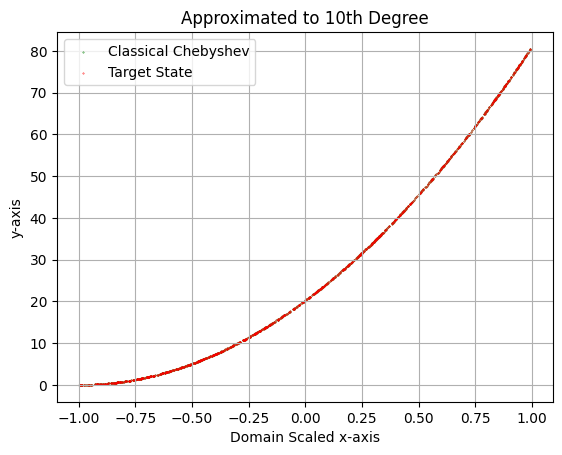

In [48]:
plt.xlabel("Domain Scaled x-axis")
plt.ylabel("y-axis")
plt.title(f"Approximated to {d}th Degree")
plt.scatter(x_array,y_classical,
             color='green', label='Classical Chebyshev',s=0.1)
plt.scatter(x_array,y,
            color='red',label='Target State', s=0.1)
plt.grid(True)
plt.legend()
plt.show()

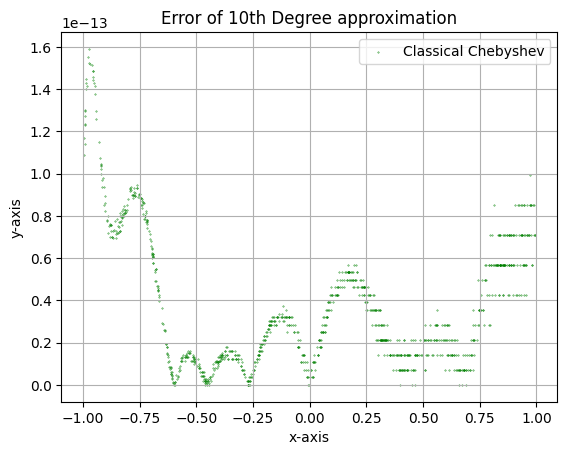

In [49]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.title(f"Error of {d}th Degree approximation")
plt.scatter(x_array,np.abs(y_classical-y),
             color='green', label='Classical Chebyshev',s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [20]:
def findNextk(ki,theta_l,theta_u,up_i,r= 2.0,):
    """
    Finds the largest integer k_next, such that the interval (4 * k_next + 2) * [theta_l, theta_u]
    lies completely in [0, 0.5] or [0.5, 1.0], where the angle is normalized.

    Args:
        ki: The current power k.
        theta_l: The lower bound of the angle interval, normalized to be in [0, 1).
        theta_u: The upper bound of the angle interval, normalized to be in [0, 1).
        up_i: Boolean flag indicating if the current interval is in the upper half-circle.
        r: Minimal ratio K_next / K_i allowed.

    Returns:
        The next power k, and a boolean flag for the new interval's half-circle.
    """
    ki_old = 4 * ki + 2  # Current scaling factor K

    # Max scaling factor K_next is bounded by the interval length.
    # K_next * (theta_u - theta_l) < 0.5  (since the half-circle has length 0.5)
    max_scaling = int(1 / (2 * (theta_u - theta_l)))

    # Find the largest candidate for K_next of the form 4k + 2 that is <= max_scaling
    k_next = max_scaling - (max_scaling - 2) % 4

    while k_next >= r * ki_old:
        # Calculate scaled interval bounds using the (x - int(x)) trick for (x mod 1.0)
        theta_min_scaled = k_next * theta_l - int(k_next * theta_l)
        theta_max_scaled = k_next * theta_u - int(k_next * theta_u)

        # **THE CRITICAL FIX IS HERE**
        
        # Check if the interval is valid (no wrap-around) AND in the upper half-circle [0, 0.5]
        # The `theta_min_scaled <= theta_max_scaled` check prevents the wrap-around error.
        if theta_min_scaled <= theta_max_scaled <= 0.5:
            return int((k_next - 2) / 4), True

        # Check if the interval is valid (no wrap-around) AND in the lower half-circle [0.5, 1.0]
        elif 0.5 <= theta_min_scaled <= theta_max_scaled:
            return int((k_next - 2) / 4), False

        # If neither is true, this k_next is invalid, so we try the next smaller one
        k_next -= 4

    # If the loop finishes without finding a suitable k_next, return the original values
    return ki, up_i

In [21]:
def AppendOperatorQ(num_qubits,qc,Qbit,polyOracle,inverted_polyOracle):
    """Appends the Q operator circuit from the A oracle."""


    # Spsi0 is just flipping the last Ancilla qubit Phase. As there are n qubits + 1 Ancilla qubit
    #  Just XZX gate to last n+1th qubit will do the job
    #  |psi0>|0>+ |psi1>|1>  ----->  -|psi0>|0> + |psi1||1>
    qc.x(Qbit[num_qubits])
    qc.z(Qbit[num_qubits])
    qc.x(Qbit[num_qubits])
    qc.barrier(Qbit)
    #For now loader and loaderInverse are just H gates. 
    # A^-1 oracle
    qc.append(inverted_polyOracle,Qbit)
    for i in range(num_qubits):
        qc.h(Qbit[i])
        
    qc.barrier(Qbit)
    # S0 is basically  I-2|0 x 0| because we are kicking back |0> in kickback
    # Basically an OR gate kickback. so |00...0> is kicked back. Everything else remains the same

    # This flips the phase of the state where all qubits in Qbit are 0.
    # Flip all qubits from |0> to |1> with X-gates
    qc.x(Qbit)

    # Apply a multi-controlled Z gate (mcz).
    # mcp(np.pi, ...) is equivalent to mcz.
    # This flips the phase of the |11...1> state.
    control_qubits = Qbit[:-1]  # All qubits except the last one
    target_qubit = Qbit[-1]     # The last qubit
    qc.mcp(np.pi, control_qubits, target_qubit)

    # Flip all qubits back with X-gates
    qc.x(Qbit)
    qc.barrier(Qbit)
    
    # A
    for i in range(num_qubits):
        qc.h(Qbit[i])
    qc.append(polyOracle,Qbit)
    qc.barrier(Qbit)

    return qc

In [50]:

polyOracle = PolynomialPauliRotations(
    num_state_qubits=num_qubits,
    coeffs=final_qiskit_coeffs,
    basis='Y',name='A_P(x)'
)

inverted_polyOracle=polyOracle.inverse()

#polyOracle= polyOracle.decompositions


In [23]:
def runCircuit(ki,N, num_qubits,polyOracle,inverted_polyOracle):
    
    Qbit= QuantumRegister(num_qubits+1,name='logical')
    C_anc= ClassicalRegister(1,name='F_anc')
    qc= QuantumCircuit(Qbit,C_anc)

    for i in range(num_qubits):
        qc.h(Qbit[i])

    qc.append(polyOracle,Qbit)
    qc.barrier(Qbit)        

    for _ in range(ki):
        qc= AppendOperatorQ(num_qubits,qc, Qbit,polyOracle,inverted_polyOracle)

    qc.measure(Qbit[num_qubits],C_anc)

    transpiled_qc= transpile(qc)
    job = sampler.run(pm.run([transpiled_qc]),shots=N)

    # Get the results
    results = job.result()[0].data

    counts= results.F_anc.get_counts()

    #  Qiskit bitstrings are ordered from the end
    #  Last Bit is the first index
    num_1=0
    for key,value in counts.items():
        if key[0]== '1':
            num_1+=value
    
    prob_1= num_1/N

    return prob_1, num_1, N

In [75]:

def ClopperPearsonInterval(counts, shots, alpha):
    """
    Calculates the Clopper-Pearson confidence interval for a binomial proportion.
    """
    # alpha is the total error prob; for a two-sided interval, use alpha/2
    lower = beta.ppf(alpha / 2, counts, shots - counts + 1) if counts > 0 else 0
    upper = beta.ppf(1 - alpha / 2, counts + 1, shots - counts) if counts < shots else 1
    return lower, upper


def IQAE(epsilon, alpha, N_shots, num_qubits, polyOracle, inverted_polyOracle):
    min_ratio = 2.0

    powers: list[int] = [0]
    ratios: list[float] = []
    theta_intervals: list[list[float]] = [[0.0, 1.0 / 4.0]]
    a_intervals: list[list[float]] = [[0.0, 1.0]]
    num_oracle_queries = 0
    num_one_shots: list[int] = []

    max_rounds = int(np.log(min_ratio * np.pi / 8.0 / epsilon) / np.log(min_ratio)) + 1
    upper_half_circle = True
    num_iterations = 0

    while theta_intervals[-1][1] - theta_intervals[-1][0] > epsilon / np.pi:
        num_iterations += 1

        k, upper_half_circle = findNextk(
            powers[-1],
            upper_half_circle,
            theta_intervals[-1][0],theta_intervals[-1][1],
            min_ratio,
        )
        powers.append(k)
        ratios.append((2 * powers[-1] + 1) / (2 * powers[-2] + 1))

        try:
            _, one_counts, shots = runCircuit(k, N_shots, num_qubits, polyOracle, inverted_polyOracle)
        except Exception as exc:
            raise RuntimeError("runCircuit failed") from exc

        num_one_shots.append(one_counts)
        num_oracle_queries += shots * k

        j = 1
        round_shots = shots
        round_one_counts = one_counts
        if num_iterations > 1:
            while num_iterations >= j + 1 and powers[num_iterations - j] == powers[num_iterations]:
                j += 1
                round_shots += shots
                round_one_counts += num_one_shots[-j]

        a_i_min, a_i_max = ClopperPearsonInterval(round_one_counts, round_shots, alpha / max_rounds)

        if upper_half_circle:
            theta_min_i = np.arccos(1 - 2 * a_i_min) / 2.0 / np.pi
            theta_max_i = np.arccos(1 - 2 * a_i_max) / 2.0 / np.pi
        else:
            theta_min_i = 1.0 - np.arccos(1- 2 * a_i_max) / 2.0 / np.pi
            theta_max_i = 1.0 - np.arccos(1 - 2 * a_i_min) / 2.0 / np.pi

        scaling = 4 * k + 2
        theta_u = (int(scaling * theta_intervals[-1][1]) + theta_max_i) / scaling
        theta_l = (int(scaling * theta_intervals[-1][0]) + theta_min_i) / scaling
        theta_intervals.append([theta_l, theta_u])

        a_u = float(np.sin(2.0 * np.pi * theta_u) ** 2)
        a_l = float(np.sin(2.0 * np.pi * theta_l) ** 2)
        a_intervals.append([a_l, a_u])

    confidence_interval = tuple(a_intervals[-1])
    estimation = float(np.mean(confidence_interval))

    result= {}
    result["alpha"] = alpha
    result["k"] = num_oracle_queries
    result["estimation"] = estimation
    result["epsilon_estimated"] = (confidence_interval[1] - confidence_interval[0]) / 2.0
    result["confidence_interval"] = confidence_interval
    result["estimate_intervals"] = a_intervals
    result["theta_intervals"] = theta_intervals
    result["powers"] = powers
    result["ratios"] = ratios
    result["num_one_shots"] = num_one_shots

    return [confidence_interval[0], confidence_interval[1]], result


In [76]:
if __name__ == '__main__':
    # --- 4. Set IQAE Parameters and Run ---
    epsilon_target = 0.01
    alpha_confidence = 0.05
    shots_per_run = 1024
    print("Starting Iterative Amplitude Estimation...")
    
    final_interval,Finalresults = IQAE(epsilon_target,alpha_confidence,shots_per_run,num_qubits
                          ,polyOracle,inverted_polyOracle)
    
    print("\n--- IQAE Complete ---")
    print(f"Final estimate interval: {final_interval}")

    for key, values in Finalresults.items():
        print(f"{key}: {values}")
    

Starting Iterative Amplitude Estimation...

--- IQAE Complete ---
Final estimate interval: [0.32999247361180345, 0.34880872101967875]
alpha: 0.05
k: 0
estimation: 0.3394005973157411
epsilon_estimated: 0.009408123703937649
confidence_interval: (0.32999247361180345, 0.34880872101967875)
estimate_intervals: [[0.0, 1.0], [0.2806531567185447, 0.35986553503200597], [0.29995822928227955, 0.35619287010557127], [0.31186540280039127, 0.357965752843247], [0.31618030654956764, 0.3561111641592164], [0.3203745763654398, 0.3561258552770137], [0.31995079836668955, 0.35252672021340786], [0.31960463389555693, 0.34971976351153977], [0.3198932834144094, 0.3480417390993784], [0.3229578978750235, 0.3495355242975219], [0.3226444415924879, 0.34783498108968736], [0.3249664889452159, 0.34901173049506806], [0.32732908958376833, 0.35037850438054224], [0.3285285420617692, 0.3506829036501311], [0.32798075720976366, 0.3493122396752325], [0.32629092165754175, 0.346866211524983], [0.32766905056626816, 0.34760452974675

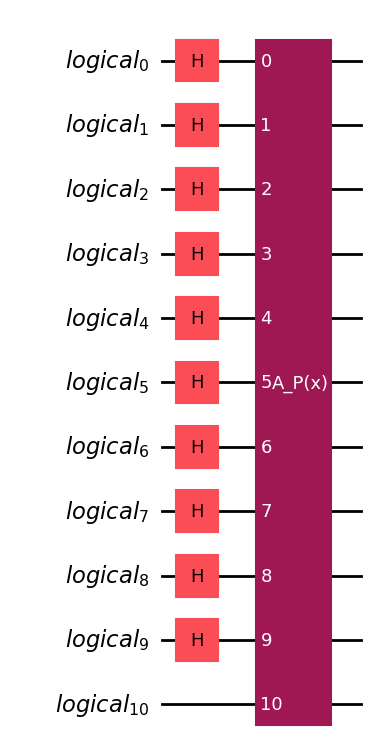

In [100]:
Qbit= QuantumRegister(num_qubits+1,name='logical')
#C_anc= ClassicalRegister(1,name='F_anc')
qc= QuantumCircuit(Qbit)

for i in range(num_qubits):
    qc.h(Qbit[i])

qc.append(polyOracle,Qbit)
#qc.barrier(Qbit)        

qc.draw(output='mpl')

In [ ]:
problem = EstimationProblem(
    state_preparation=qc,
    objective_qubits=[num_qubits]  # List of indices for your ancilla qubit(s)
)


# --- 3. Instantiate and Run IterativeAmplitudeEstimation ---
# Set your desired precision (epsilon) and confidence level (alpha).

epsilon_target = 0.01  # Target precision (e.g., 1% absolute error)
alpha = 0.05           # Confidence level (1 - alpha = 95% confidence)


iqae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon_target,
    alpha=alpha,
    sampler=sampler,
    transpiler=pm
)

# Run the algorithm on your problem
print("--- Running Iterative Amplitude Estimation ---")
result = iqae.estimate(problem)
print("-" * 50)


# --- 4. Display the High-Precision Results ---


--- Running Iterative Amplitude Estimation ---
--------------------------------------------------
--- IQAE Results ---
Target Precision (epsilon): 0.01


AttributeError: 'IterativeAmplitudeEstimation' object has no attribute 'alpha'

In [112]:

print("--- IQAE Results ---")
print(f"Target Precision (epsilon): {iqae.epsilon_target}")
print(f"Confidence Level (1 - alpha): {1 - iqae._alpha}")
print("-" * 20)
# The final estimated probability 'a'
print(f"🎯 Estimated Probability (a): {result.estimation_processed:.6f}")
# The confidence interval for the true value of 'a'
print(f"Confidence Interval: [{result.confidence_interval_processed[0]:.6f}, {result.confidence_interval_processed[1]:.6f}]")
print(f"Total Oracle Queries: {result.num_oracle_queries}")
print("-" * 50)

--- IQAE Results ---
Target Precision (epsilon): 0.01
Confidence Level (1 - alpha): 0.95
--------------------
🎯 Estimated Probability (a): 0.333632
Confidence Interval: [0.330917, 0.336347]
Total Oracle Queries: 7168
--------------------------------------------------


In [110]:
Qbit = QuantumRegister(num_qubits + 1, name='logical')
qc = QuantumCircuit(Qbit)
for i in range(num_qubits):
    qc.h(Qbit[i])
qc.append(polyOracle.decompose(), Qbit)


transpiled_qc = transpile(qc, backend)

problem = EstimationProblem(
    state_preparation=transpiled_qc,
    objective_qubits=[num_qubits]
)

# 2. Instantiate IQAE (but we won't run .estimate() yet)
# We use the V1 Sampler here for maximum compatibility in this direct test
iqae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.05, sampler=sampler,transpiler=pm) 

# --- DEBUGGING SCRIPT ---
# 3. Manually construct and run a single circuit to get the real error
try:
    # Construct a circuit with k=1 (one Grover iteration)
    # This forces the creation of the Grover operator A*S0*A_dagger*S_chi
    print("--- Attempting to construct a test circuit... ---")
    test_circuit = iqae.construct_circuit(problem, k=1, measurement=True)
    print("Circuit constructed successfully.")
    
    # 4. Try to run this single circuit directly with the sampler
    print("\n--- Running the circuit directly with the sampler... ---")
    job = sampler.run([test_circuit], shots=100)
    result = job.result()
    
    print("\n--- ✅ Direct run successful! ---")
    print("This means the issue lies within the IQAE iteration logic.")
    print(result)

except Exception as e:
    print("\n--- 🚨 An error occurred during the direct run ---")
    print("This traceback will be more specific than the previous one.")
    # Print the full traceback to see the specific AerError
    import traceback
    traceback.print_exc()

--- Attempting to construct a test circuit... ---
Circuit constructed successfully.

--- Running the circuit directly with the sampler... ---

--- ✅ Direct run successful! ---
This means the issue lies within the IQAE iteration logic.
PrimitiveResult([SamplerPubResult(data=DataBin(c13=BitArray(<shape=(), num_shots=100, num_bits=1>)), metadata={'shots': 100, 'circuit_metadata': {}})], metadata={'version': 2})


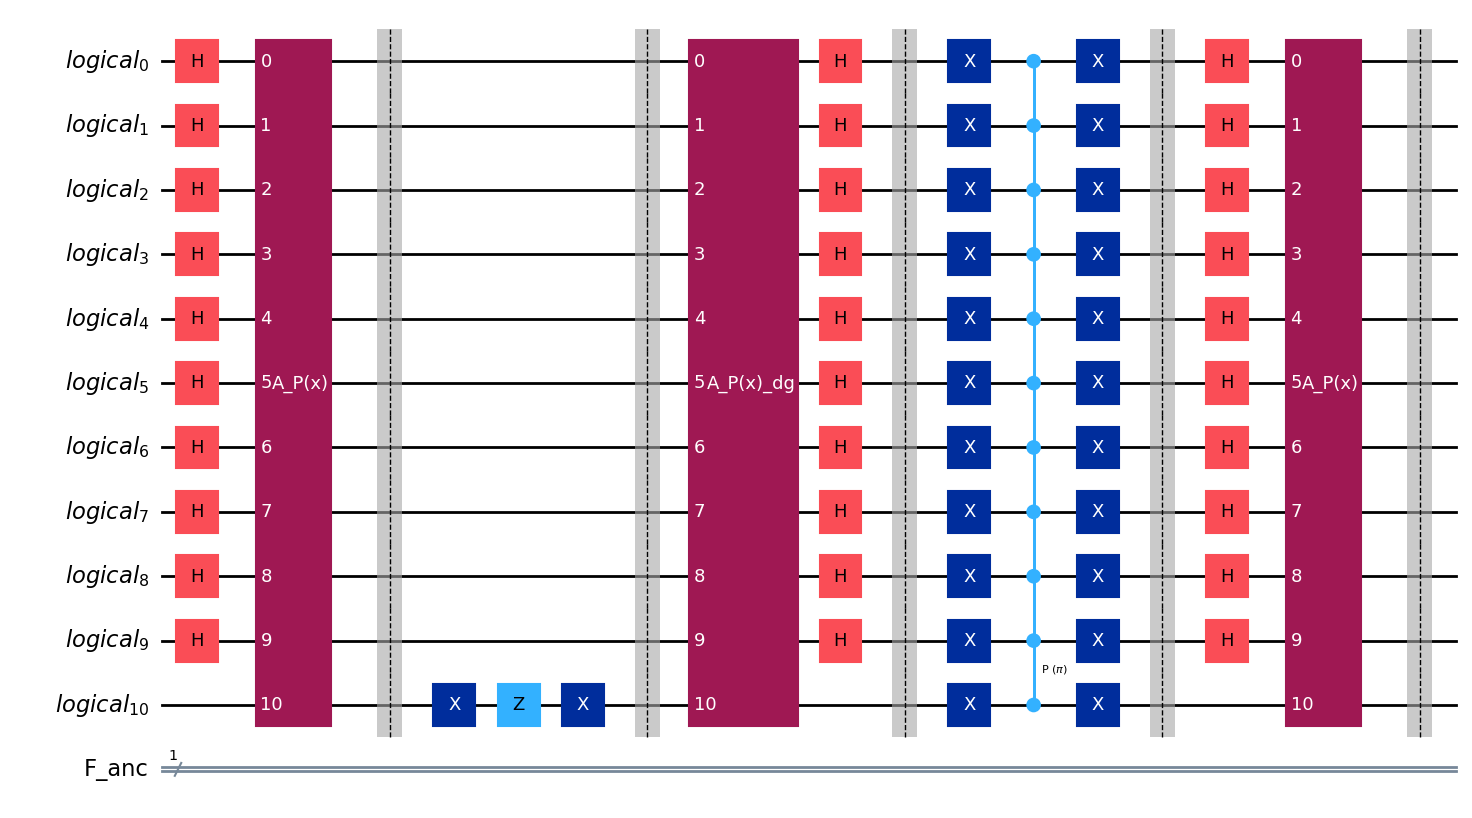

In [25]:
qc= AppendOperatorQ(num_qubits,qc, Qbit,polyOracle,inverted_polyOracle)
qc.draw(output='mpl')

In [62]:
qc.measure(Qbit[num_qubits],C_anc)

transpiled_qc= transpile(qc)

In [73]:
job = sampler.run(pm.run([transpiled_qc]),shots=N)

# Get the results
results = job.result()[0].data

counts= results.F_anc.get_counts()

#  Qiskit bitstrings are ordered from the end
#  Last Bit is the first index
num_1=0
for key,value in counts.items():
    if key[0]== '1':
        num_1+=value
    
prob_1= num_1/N

print(prob_1)

0.3271484375


In [113]:
Quantum_Integral_value=0.333632*(upper_limit-lower_limit)*(float(M)-float(m))
print(Quantum_Integral_value)

243.21772800000008
